Here we will build prediction model based on the data produced at the ETL stage. We will compare:
- baseline, which will be a linear model based on 1 feature "number_of_panels_total"
- linear model with all the rest features
- linear model with features produced by one layer MLP
- random forest
- adaboost
- xgboost

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet

# Data initiation

In [2]:
df = pd.read_csv('datasets/modeling_df.csv')
all_feats = [
    'lat_max',
    'lat_min',
    'long_max',
    'long_min',
    'number_of_panels_north',
    'number_of_panels_south',
    'number_of_panels_east',
    'number_of_panels_west',
    'number_of_panels_flat',
    'number_of_panels_total',
    'lat_mean',
    'long_mean',
    'zip_area',
    'dens',
    'approx_zips',
    'is_usa',
    'zip_lat',
    'zip_long',
    'state_size',
    'state_lat',
    'state_long'
]
label = 'potential_kwh_total'

In [10]:
for col in all_feats:
    print(col, df[col].isna().sum())

lat_max 0
lat_min 0
long_max 0
long_min 0
number_of_panels_north 0
number_of_panels_south 0
number_of_panels_east 0
number_of_panels_west 0
number_of_panels_flat 0
number_of_panels_total 0
lat_mean 0
long_mean 0
zip_area 0
dens 0
approx_zips 0
is_usa 0
zip_lat 0
zip_long 0
state_size 0
state_lat 0
state_long 0


In [4]:
df[df['zip_lat'].isna()]

,lat_max,lat_min,long_max,long_min,number_of_panels_north,number_of_panels_south,number_of_panels_east,number_of_panels_west,number_of_panels_flat,number_of_panels_total,...,zip_area,dens,approx_zips,is_usa,zip_lat,zip_long,state_size,state_lat,state_long,potential_kwh_total


# Baseline

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df[['number_of_panels_total']].values, df[[label]].values, test_size=.2)
baseline_model = linear_model.LinearRegression(positive=True)
y_pred = baseline_model.fit(X_train, y_train).predict(X_test)

In [6]:
baseline_rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
baseline_rmse

10.380845932415188

In [7]:
np.std(df[label]) / baseline_rmse

6.373382590774897

In [8]:
iqr = df[label].quantile(.75) - df[label].quantile(.25)
iqr / baseline_rmse

8.436246086798908

In [9]:
r2_score(y_pred=y_pred, y_true=y_test)

0.9759228785342854

Baseline model is only about 17% of label std and about 12% of iqr and very high r2 score. It will probably be hard to beat.

# Regularised linear model with all features

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df[all_feats].values, df[[label]].values, test_size=.2)
baseline_model = ElasticNet()
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

In [13]:
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
rmse

8.207480128855872

In [14]:
r2_score(y_pred=y_pred, y_true=y_test)

0.9822582748309582

Interesting, so we managed to beat the baseline model with a regularised linear model. Let's see what features helped the most.

<AxesSubplot: ylabel='0'>

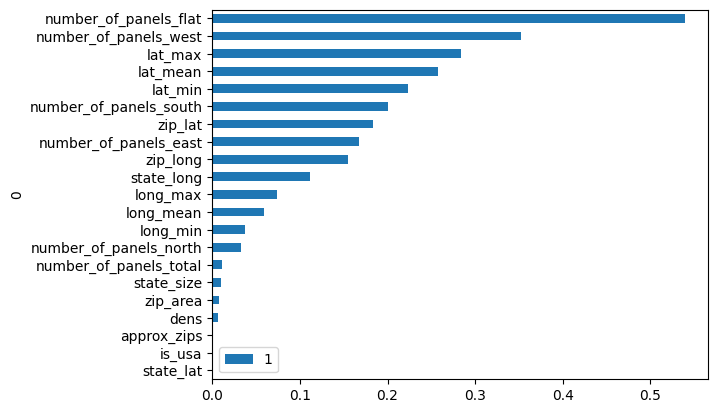

In [34]:
pd.DataFrame(sorted(zip(all_feats, baseline_model.coef_), key=lambda x: x[1])).set_index(0).abs().sort_values(1).plot(kind='barh')